In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Basic Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px 
from PIL import Image


# Neural Network Library
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, TimeDistributed, Reshape
from keras.activations import relu, softmax, sigmoid
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [3]:
DATA_PATH = "DATASET_STORE\\UPDATE DATASET_1.csv"
df = pd.read_csv(DATA_PATH)
df['datetime'] = pd.to_datetime(df['datetime'])
df1 = df[df['datetime']>= '1980-01-01 00:00:01']
df1.shape

(901188, 40)

In [4]:
df1 = df[df['mag'] >= 3]
df1.shape

(723058, 40)

In [5]:
import plotly.express as px 

reduced_data = df1.iloc[-5000:, :]

fig = px.scatter_geo(reduced_data,
                     lat="latitude",
                     lon="longitude",
                     title="Earthquake Position")


fig.update_layout(height=500, width=800) 

fig.show()

# img = mpimg.imread('DATASET_STORE/earth.jpg')
# plt.figure(figsize=(10, 6))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [6]:
# Star position Heatmap

star_position_columns = ['SUN_x', 'SUN_y', 'SUN_z',
                         'MERCURY BARYCENTER_x', 'MERCURY BARYCENTER_y', 'MERCURY BARYCENTER_z', 
                         'VENUS BARYCENTER_x', 'VENUS BARYCENTER_y', 'VENUS BARYCENTER_z',
                         'MOON_x', 'MOON_y', 'MOON_z',
                         'MARS_x', 'MARS_y', 'MARS_z',
                         'JUPITER BARYCENTER_x', 'JUPITER BARYCENTER_y', 'JUPITER BARYCENTER_z',
                         'SATURN BARYCENTER_x', 'SATURN BARYCENTER_y', 'SATURN BARYCENTER_z',
                         'URANUS BARYCENTER_x', 'URANUS BARYCENTER_y', 'URANUS BARYCENTER_z',
                         'NEPTUNE BARYCENTER_x', 'NEPTUNE BARYCENTER_y', 'NEPTUNE BARYCENTER_z']

# star_positions = df1[star_position_columns]

# correlation_matrix = star_positions.corr()

# plt.figure(figsize=(16, 12))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
# plt.title('Correlation Matrix of Star Positions')
# plt.show()
df1['longitude'].max(), df1['longitude'].min()

(180.0, -179.9997)

In [7]:
## Data Preparing
# The Pacific Plate

In [8]:
fillter = (df1['latitude'] >= -59.889) & (df1['latitude'] <= 65.026) & \
          ((df1['longitude'] >= 139.219) & (df1['longitude'] <= 267.188) | (df1['longitude'] >= -180) & (df1['longitude'] <= (-267.188+180))) & \
          (df1['datetime']>= '1980-01-01 00:00:01')

df_pacific = df1[fillter]       # This Union with Australia Plate and Califonia Plate and Nazaca Plate

# Remove Australia Plate
au_filter = ~(((df_pacific['latitude'] > -60) & (df_pacific['latitude']  < -19.83) & 
              (df_pacific['longitude'] > 139) & (df_pacific['longitude'] < 151.2)) |
              ((df_pacific['latitude'] > -40.5) & (df_pacific['latitude']  < -20) & 
              (df_pacific['longitude'] > 151) & (df_pacific['longitude'] < 161))  
             )
df_pacific = df_pacific[au_filter]

# Remove North America Plate and Eurasia Plate and Nazca Plate
na_filter = ~(
    ((df_pacific['latitude'] >= 61) & (df_pacific['latitude'] <= 65) & (df_pacific['longitude'] >= -135) & (df_pacific['longitude'] <= -87)) |
    ((df_pacific['latitude'] >= 54) & (df_pacific['latitude'] <= 57) & (df_pacific['longitude'] >= -122) & (df_pacific['longitude'] <= -115)) |
    ((df_pacific['latitude'] >= 37) & (df_pacific['latitude'] <= 47) & (df_pacific['longitude'] >= -115.5) & (df_pacific['longitude'] <= -87)) |
    ((df_pacific['latitude'] >= 31.6) & (df_pacific['latitude'] <= 37) & (df_pacific['longitude'] >= -112.5) & (df_pacific['longitude'] <= -95)) |
    ((df_pacific['latitude'] >= 27.5) & (df_pacific['latitude'] <= 30.5) & (df_pacific['longitude'] >= -109.2) & (df_pacific['longitude'] <= -89)) |
    ((df_pacific['latitude'] >= 14) & (df_pacific['latitude'] <= 23.1) & (df_pacific['longitude'] >= -100.5) & (df_pacific['longitude'] <= -87)) |
    ((df_pacific['latitude'] >= -1) & (df_pacific['latitude'] <= 14) & (df_pacific['longitude'] >= -99) & (df_pacific['longitude'] <= -87)) | 
    ((df_pacific['latitude'] >= -49) & (df_pacific['latitude'] <= -17) & (df_pacific['longitude'] >= -106.5) & (df_pacific['longitude'] <= -85)) | 
    ((df_pacific['latitude'] >= 58.3) & (df_pacific['latitude'] <= 66) & (df_pacific['longitude'] >= 140) & (df_pacific['longitude'] <= 180)) | 
    ((df_pacific['latitude'] >= 58.3) & (df_pacific['latitude'] <= 66) & (df_pacific['longitude'] >= -180) & (df_pacific['longitude'] <= -167)) |
    ((df_pacific['latitude'] >= 30) & (df_pacific['latitude'] <= 66) & (df_pacific['longitude'] >= -105) & (df_pacific['longitude'] <= 0))
)

df_pacific = df_pacific[na_filter]


df_pacific.shape


(285212, 40)

In [9]:
plt_data = df_pacific.iloc[-2000:, :]

fig = px.scatter_geo(plt_data,
                     lat="latitude",
                     lon="longitude",
                     title="Earthquake Position")
fig.update_layout(height=500, width=800) 
fig.show()

In [10]:
# Model

data = df_pacific[['latitude', 'longitude', 'SUN_x', 'SUN_y', 'SUN_z', 'distance_sun',
           'MERCURY BARYCENTER_x', 'MERCURY BARYCENTER_y', 'MERCURY BARYCENTER_z', 'distance_mercury barycenter',
           'VENUS BARYCENTER_x', 'VENUS BARYCENTER_y', 'VENUS BARYCENTER_z', 'distance_venus barycenter',
           'MOON_x', 'MOON_y', 'MOON_z', 'distance_moon', 'MARS_x', 'MARS_y', 'MARS_z', 'distance_mars',
           'JUPITER BARYCENTER_x', 'JUPITER BARYCENTER_y', 'JUPITER BARYCENTER_z', 'distance_jupiter barycenter',
           'SATURN BARYCENTER_x', 'SATURN BARYCENTER_y', 'SATURN BARYCENTER_z', 'distance_saturn barycenter',
           'URANUS BARYCENTER_x', 'URANUS BARYCENTER_y', 'URANUS BARYCENTER_z', 'distance_uranus barycenter',
           'NEPTUNE BARYCENTER_x', 'NEPTUNE BARYCENTER_y', 'NEPTUNE BARYCENTER_z', 'distance_neptune barycenter']]

data = data.values

scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()

scaler_features.fit(data[:, :2])
scaler_targets.fit(data[:, :2])

data[:, :2] = scaler_features.transform(data[:, :2])

In [11]:
time_steps = 10  
num_features = data.shape[1]

# time steps and features
time_steps = 10 
num_features = data.shape[1]

In [12]:
sequences = []
targets = []
for i in range(len(data) - time_steps):
    sequences.append(data[i:i+time_steps])
    targets.append(data[i+time_steps, 0:2])  # Predict latitude and longitude

sequences = np.array(sequences)
targets = np.array(targets)

In [13]:
# Define a model
input_layer = Input(shape=(time_steps, num_features))

# Reshape input to channel dimension in Conv1D
reshaped_input = Reshape((time_steps, num_features, 1))(input_layer)

In [14]:
# CNN
conv1 = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(reshaped_input)
pool1 = TimeDistributed(MaxPooling1D(pool_size=2))(conv1)
conv2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(pool1)
pool2 = TimeDistributed(MaxPooling1D(pool_size=2))(conv2)
flatten = TimeDistributed(Flatten())(pool2)

In [15]:
# LSTM
lstm_out = LSTM(units=50, return_sequences=False)(flatten)

In [16]:
# Dense
dense1 = Dense(units=64, activation='relu')(lstm_out)
dense2 = Dense(units=32, activation='relu')(dense1)
output_layer = Dense(units=2, activation='linear')(dense2)  # Predict latitude and longitude

In [17]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 38)]          0         
                                                                 
 reshape (Reshape)           (None, 10, 38, 1)         0         
                                                                 
 time_distributed (TimeDistr  (None, 10, 36, 32)       128       
 ibuted)                                                         


                                                                 
 time_distributed_1 (TimeDis  (None, 10, 18, 32)       0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 16, 64)       6208      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 8, 64)        0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 512)          0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                112600    
                                                                 
 dense (De

In [19]:
model.fit(sequences, targets, epochs=3, batch_size=32)

Epoch 1/3
8913/8913 [==============================] - 97s 11ms/step - loss: 0.1201
Epoch 2/3
8913/8913 [==============================] - 99s 11ms/step - loss: 0.1161
Epoch 3/3
8913/8913 [==============================] - 100s 11ms/step - loss: 0.1152


In [20]:
model.save('ModelTraining/Pacific_DATA_training.h5')

In [21]:
predictions = model.predict(sequences)
predictions = scaler_targets.inverse_transform(predictions)
targets_original = scaler_targets.inverse_transform(targets)

8913/8913 [==============================] - 46s 5ms/step


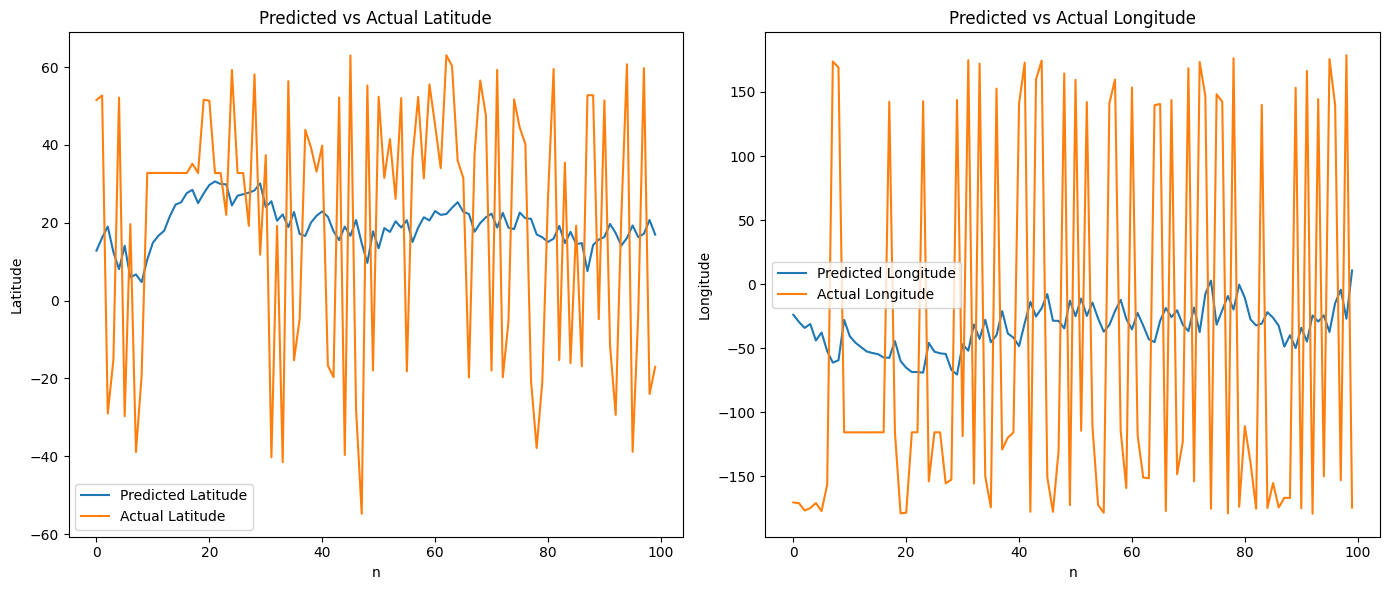

In [23]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(predictions[-100:, 0], label='Predicted Latitude')
plt.plot(targets_original[-100:, 0], label='Actual Latitude')
plt.title('Predicted vs Actual Latitude')
plt.xlabel('n')
plt.ylabel('Latitude')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(predictions[-100:, 1], label='Predicted Longitude')
plt.plot(targets_original[-100:, 1], label='Actual Longitude')
plt.title('Predicted vs Actual Longitude')
plt.xlabel('n')
plt.ylabel('Longitude')
plt.legend()

plt.tight_layout()
plt.show()